<a href="https://github.com/VUZhuangweiKang/K8sDDS/blob/main/Notebooks/latency-parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
# encoding: utf-8
# Author: Zhuangwei Kang
%matplotlib inline
import matplotlib.pyplot as plt
from datapsr import *
import numpy as np

In [81]:
plugins = ['flannel-hostgw', 'flannel-vxlan', 'kube-router', 'weavenet']

udp_plugins = ['%s-udp' % p for p in plugins]
udp_dds_secure_plugins = ['%s-dds-secure-udp' % p for p in plugins]
tcp_plugins = ['%s-tcp' % p for p in plugins]
tcp_dds_secure_plugins = ['%s-dds-secure-tcp' % p for p in plugins]
tls_plugins = ['%s-tls' % p for p in plugins]

data_len = [64, 256, 1024, 4096, 16384, 63000]

In [82]:
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['figure.figsize'] = (8, 5) 
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 12

all_colors = ['#e6194B', '#3cb44b', '#4363d8', '#f58231', '#911eb4', '#800000', '#808000', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#aaffc3', '#ffd8b1', '#000075', '#a9a9a9','#000000']
# all_colors = ['C%d' %x for x in range(10)]

In [83]:
def plotThroughput(plugins):
    # dataLen test
    throughput_perf, _ = load_data(range(6), plugins, latencyTest=True)

    plt.xticks(range(len(data_len)), data_len)
    cell_text = []
    for i, cni in enumerate(plugins):
        throughput = throughput_perf[throughput_perf['cni'] == cni]['mbps(ave)']
        cell_text.append(['%.1f' % thr for thr in throughput])
        plt.plot(np.arange(6), throughput, label=cni, marker='*', color=all_colors[i])
        # plt.scatter(x, thr, s=10, color=all_colors[i])

    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                        rowLabels=plugins,
                        cellLoc='center',
                        rowColours=all_colors[:len(plugins)],
                        colLabels=data_len,
                        loc='bottom')
                        
    the_table.set_fontsize(15)
    the_table.scale(1, 1.5)
    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)

    # plt.legend()
    # plt.xlabel('dataLen(B)')
    plt.ylabel('throughput(Mbps)', fontsize=15)
    plt.xticks([])
    plt.grid(axis='y', linestyle=':')
    plt.show()

# sendQueueSize=15 for 63KB and 50 otherwise

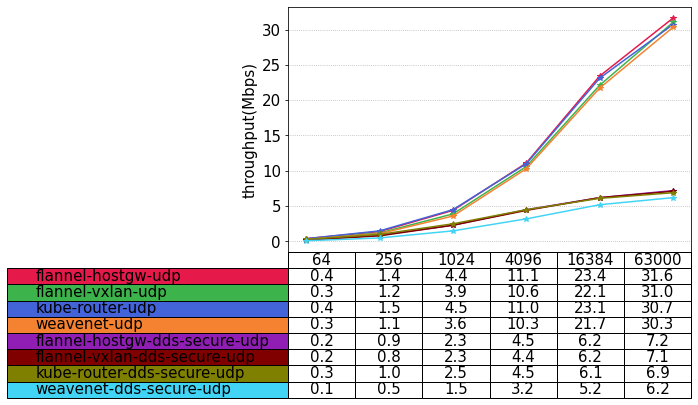

In [84]:
plotThroughput(udp_plugins + udp_dds_secure_plugins)

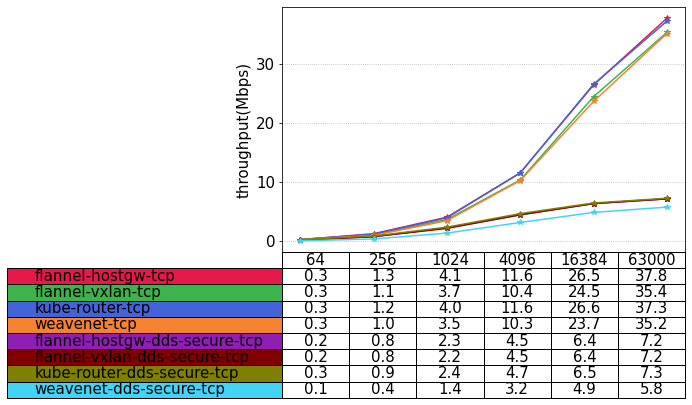

In [85]:
plotThroughput(tcp_plugins + tcp_dds_secure_plugins)

In [86]:
def plotPingPongLatency(plugins):
    _, latency_perf = load_data(range(6), plugins, latencyTest=True)

    plt.xticks(range(len(data_len)), data_len)
    cell_text = []
    # plt.xticks(range(len(data_len)), data_len, rotation=0)
    for i, cni in enumerate(plugins):
        lat = latency_perf[latency_perf['cni'] == cni]['90%']
        cell_text.append(['%.1f' % thr for thr in lat])
        plt.plot(np.arange(6), lat, label=cni, marker='*', color=all_colors[i])
    
    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                        rowLabels=plugins,
                        cellLoc='center',
                        rowColours=all_colors[:len(plugins)],
                        colLabels=data_len,
                        loc='bottom')

    the_table.set_fontsize(15)
    the_table.scale(1, 1.5)
    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)

    # plt.legend()
    # plt.xlabel('dataLen(B)')
    plt.ylabel('90th latency(us)', fontsize=15)
    plt.grid(axis='y', linestyle=':')
    plt.xticks([])
    plt.show()

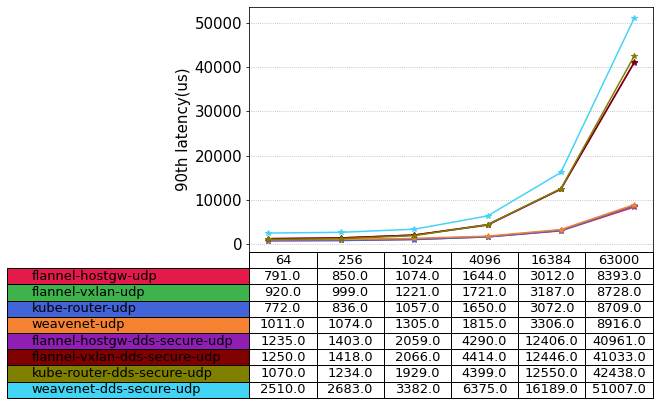

In [87]:
plotPingPongLatency(udp_plugins + udp_dds_secure_plugins)

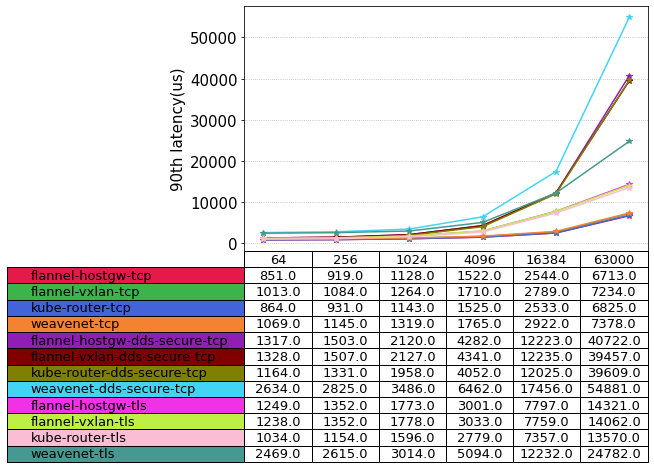

In [88]:
plotPingPongLatency(tcp_plugins + tcp_dds_secure_plugins + tls_plugins)

In [89]:
reliable_config = ['UDP-Reliable', 'UDP-BestEffort', 'TCP-Reliable', 'TCP-BestEffort', 'TLS-Reliable', 'TLS-BestEffort']
raw_cnis = ['flannel-hostgw', 'flannel-vxlan', 'kube-router', 'weavenet', 'flannel-hostgw-dds-secure', 'flannel-vxlan-dds-secure', 'kube-router-dds-secure', 'weavenet-dds-secure']

In [90]:
# reliability test
def plotReliableLatency():
    _, udp_latency_perf = load_data([6, 7], udp_plugins + udp_dds_secure_plugins, latencyTest=True)
    udp_tests = udp_latency_perf['test'].tolist()
    cnis = udp_latency_perf['cni'].tolist()
    to_raw_cni = lambda my_cnis: ['-'.join(c.split('-')[:-1]) for c in my_cnis]
    cnis = to_raw_cni(cnis)
    udp_latency_perf['cni'] = cnis
    for i, t in enumerate(udp_tests[:]):
        if t == 6:
            udp_tests[i] = 'UDP-Reliable'
        else:
            udp_tests[i] = 'UDP-BestEffort'
    udp_latency_perf['test'] = udp_tests

    _, tcp_latency_perf = load_data([6, 7], tcp_plugins + tcp_dds_secure_plugins, latencyTest=True)
    tcp_tests = tcp_latency_perf['test'].tolist()
    cnis = tcp_latency_perf['cni'].tolist()
    cnis = to_raw_cni(cnis)
    tcp_latency_perf['cni'] = cnis
    for i, t in enumerate(tcp_tests[:]):
        if t == 6:
            tcp_tests[i] = 'TCP-Reliable'
        else:
            tcp_tests[i] = 'TCP-BestEffort'
    tcp_latency_perf['test'] = tcp_tests

    _, tls_latency_perf = load_data([6, 7], tls_plugins, latencyTest=True)
    tls_tests = tls_latency_perf['test'].tolist()
    cnis = tls_latency_perf['cni'].tolist()
    cnis = to_raw_cni(cnis)
    tls_latency_perf['cni'] = cnis
    for i, t in enumerate(tls_tests[:]):
        if t == 6:
            tls_tests[i] = 'TLS-Reliable'
        else:
            tls_tests[i] = 'TLS-BestEffort'
    tls_latency_perf['test'] = tls_tests

    latency_perf = pd.concat([udp_latency_perf, tcp_latency_perf, tls_latency_perf])
    latency_perf = latency_perf.reset_index(drop=True)
    
    x = np.arange(len(raw_cnis))
    plt.xticks(x, raw_cnis, rotation=30, ha='right')
    total_width, n = 0.8, len(reliable_config)
    width = total_width / n
    x = x - (total_width - width) / 2

    for i, l in enumerate(reliable_config):
        thr = []
        std = []
        for cni in raw_cnis:
            tmp1 = latency_perf[(latency_perf['test'] == l) & (latency_perf['cni'] == cni)]['latencyave']
            tmp2 = latency_perf[(latency_perf['test'] == l) & (latency_perf['cni'] == cni)]['std'].tolist()
            if len(tmp1) == 0:
                thr.append(0)
                std.append(0)
            else:
                thr.extend(tmp1)
                std.append(tmp2)
  
        plt.bar(x+i*width, thr, label=reliable_config[i], width=width, yerr=std, capsize=5)

    plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncol=4)
    # plt.xlabel('cni')
    plt.ylabel('Ave latency(ns)')
    plt.grid(axis='y', linestyle=':')
    plt.show()

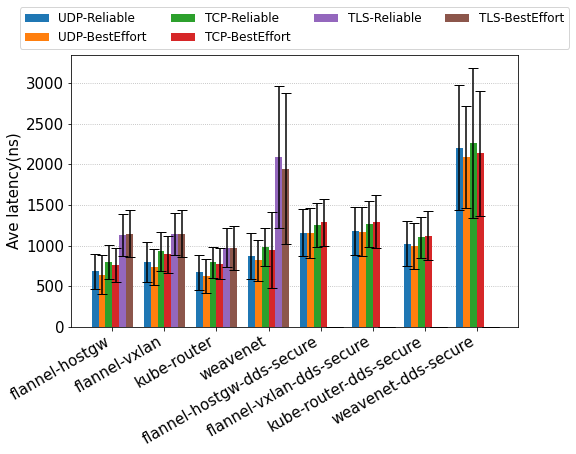

In [91]:
plotReliableLatency()

In [92]:
multicast_plugins = ['weavenet-udp', 'weavenet-encryption-udp', 'weavenet-dds-secure-udp', 'hostnetwork-udp']
multicast_test = [12,13,14,15]

In [93]:
def plotMulticastLatency():
    # multicast test
    _, latency_perf = load_data(multicast_test,  multicast_plugins, latencyTest=True)
    num_subs = [1,2,4,8]

    plt.xticks(np.arange(4), num_subs, rotation=0)
    for i, cni in enumerate(multicast_plugins):
        thr = latency_perf[latency_perf['cni'] == cni]['90%']
        plt.plot(np.arange(4), thr, label=cni, marker='*', color=all_colors[i])
    plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncol=2)
    plt.xlabel('numSubscribers')
    plt.ylabel('90th latency(us)')
    plt.grid(axis='y', linestyle=':')
    plt.show()

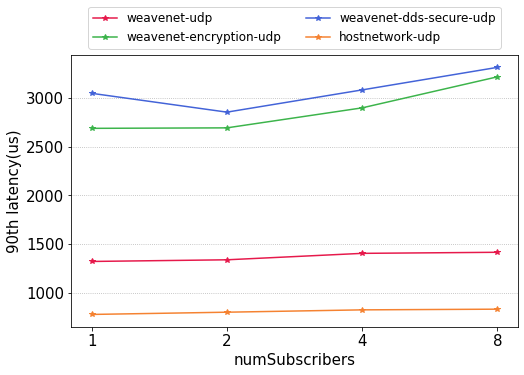

In [94]:
plotMulticastLatency()

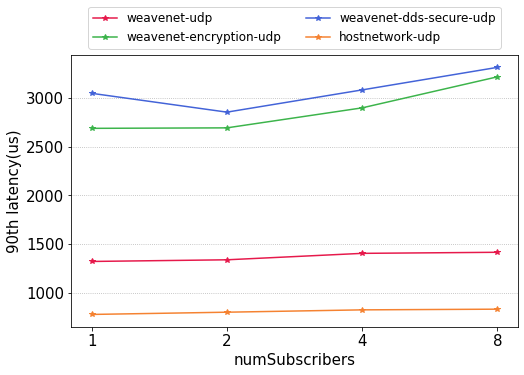

In [95]:
plotMulticastLatency()

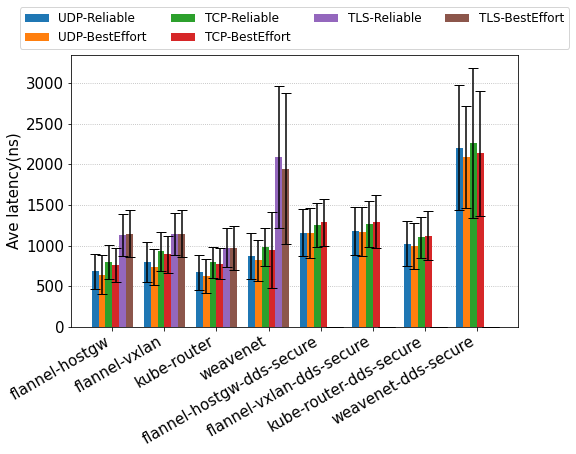

In [96]:
plotReliableLatency()

In [97]:
multicast_plugins = ['weavenet-udp', 'weavenet-encryption-udp', 'weavenet-dds-secure-udp', 'hostnetwork-udp']
multicast_test = [12,13,14,15]

In [98]:
def plotMulticastLatency():
    # multicast test
    _, latency_perf = load_data(multicast_test,  multicast_plugins, latencyTest=True)
    num_subs = [1,2,4,8]

    plt.xticks(np.arange(4), num_subs, rotation=0)
    for i, cni in enumerate(multicast_plugins):
        thr = latency_perf[latency_perf['cni'] == cni]['90%']
        plt.plot(np.arange(4), thr, label=cni, marker='*', color=all_colors[i])
    plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncol=2)
    plt.xlabel('numSubscribers')
    plt.ylabel('90th latency(us)')
    plt.grid(axis='y', linestyle=':')
    plt.show()

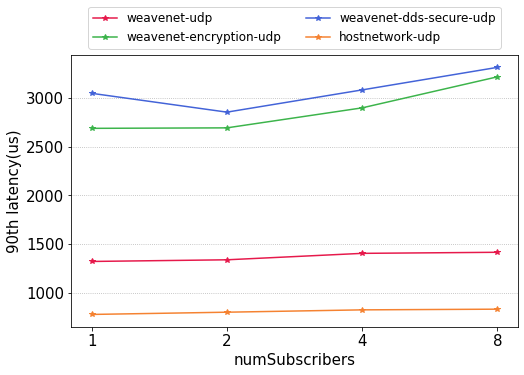

In [99]:
plotMulticastLatency()